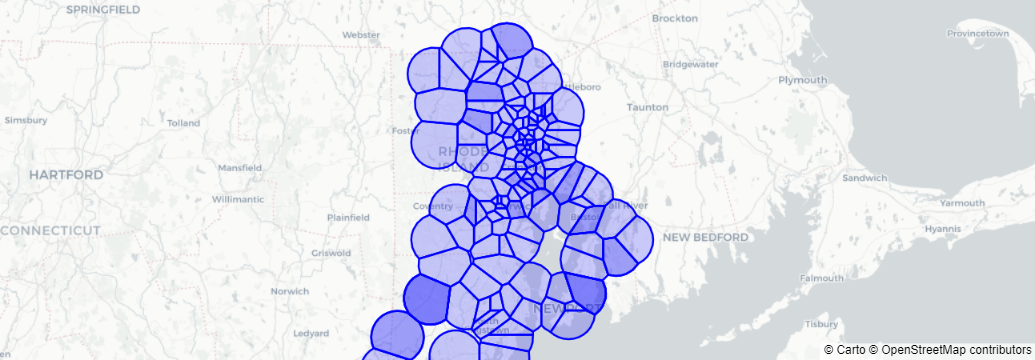

In [5]:
# Use plotly to create more interactive map with additional detail

import pandas as pd
import geopandas as gpd
from shapely.ops import unary_union
from shapely.geometry import Point, Polygon
from scipy.spatial import Voronoi
import numpy as np
import plotly.graph_objects as go

# Load data
loc_data = pd.read_csv('dunkin.csv')

# Convert store data to a gdf
geometry = [Point(xy) for xy in zip(loc_data.lon, loc_data.lat)]
gdf = gpd.GeoDataFrame(loc_data, geometry=geometry)
gdf.crs = "EPSG:4326"
gdf = gdf.to_crs(epsg=3857)

# Convert 5 miles to meters (1 mile = 1609.34 meters)
five_mile_radius = 5 * 1609.34

# Generate 5-mile radius buffers around each point
gdf['buffer'] = gdf.geometry.buffer(five_mile_radius)


gdf = gdf[['branch', 'Address', 'City', 'buffer']].rename(columns={'buffer': 'geometry'})

# Calculate centroids of each polygon
gdf['centroid'] = gdf.geometry.centroid

# Extract the centroids as a numpy array for Voronoi diagram creation
centroids = np.array([(point.x, point.y) for point in gdf['centroid']])

# Define the bounding box with a slight extension to allow all polygons to show on plot
min_x, min_y, max_x, max_y = unary_union(gdf.geometry).bounds
buffer_distance = five_mile_radius
bbox_extension = 2 * buffer_distance  

dummy_points = [
    [min_x - bbox_extension, min_y - bbox_extension],
    [min_x - bbox_extension, max_y + bbox_extension],
    [max_x + bbox_extension, min_y - bbox_extension],
    [max_x + bbox_extension, max_y + bbox_extension]
]

centroids = np.vstack([centroids, dummy_points])

# Create the Voronoi diagram
vor = Voronoi(centroids)

# Create a list to hold the resulting geometries
result_geometries = []

# Define the bounding box to clip Voronoi regions (extended version)
bounding_box = Polygon([
    (min_x - bbox_extension, min_y - bbox_extension),
    (min_x - bbox_extension, max_y + bbox_extension),
    (max_x + bbox_extension, max_y + bbox_extension),
    (max_x + bbox_extension, min_y - bbox_extension)
])

# Iterate through Voronoi regions and branch polygons
for region_idx, point_idx in enumerate(vor.point_region):
    region = vor.regions[point_idx]
    if not -1 in region:  
        # Create a polygon for the region
        polygon = Polygon([vor.vertices[i] for i in region])
        # Clip the region with the bounding box and branch polygon
        polygon = polygon.intersection(bounding_box)
        if region_idx < len(gdf):  # Only process actual data points, not dummy ones
            branch_polygon = gdf.geometry.iloc[region_idx]
            clipped_region = polygon.intersection(branch_polygon)
            result_geometries.append((clipped_region, gdf.iloc[region_idx]))

# Create a new gdf with the resulting geometries
result_gdf = gpd.GeoDataFrame(
    [(geom, data['branch'], data['Address'], data['City']) for geom, data in result_geometries],
    columns=['geometry', 'branch', 'Address', 'City'],
    crs=gdf.crs
)

# Reproject for Plotly
result_gdf = result_gdf.to_crs(epsg=4326)
gdf = gdf.to_crs(epsg=4326)

# Extract coordinates for store points from original data
store_lats = loc_data['lat']
store_lons = loc_data['lon']

# Plotly plot
fig = go.Figure()

# Add polygons to the plot
for _, row in result_gdf.iterrows():
    geom = row['geometry']
    if geom.is_empty:
        continue
    x, y = geom.exterior.xy
    fig.add_trace(go.Scattermapbox(
        fill='toself',
        fillcolor='rgba(0, 0, 255, 0.2)',  # Blue color with transparency
        line=dict(color='blue'),
        lat=np.array(y).tolist(),
        lon=np.array(x).tolist(),
        mode='lines',
        hoverinfo='text',
        text=f"Branch: {row['branch']}<br>Address: {row['Address']}<br>City: {row['City']}"
    ))

# Layout settings for the plot
fig.update_layout(
    mapbox=dict(
        style='carto-positron',
        zoom=8,
        center=dict(lat=np.mean(store_lats), lon=np.mean(store_lons))
    ),
    margin=dict(l=0, r=0, t=0, b=0),
    showlegend=False
)

fig.show()
